🔮 Forecasting expected returns with Ridge Regression...


C:\Users\chris\AppData\Local\Temp\ipykernel_21424\409472218.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i+forecast_horizon])
C:\Users\chris\AppData\Local\Temp\ipykernel_21424\409472218.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i+forecast_horizon])
C:\Users\chris\AppData\Local\Temp\ipykernel_21424\409472218.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i+forec

✅ Forecasted expected returns (1-month):
SCHW    0.010699
XOM     0.010355
SNOW    0.010161
PANW    0.006600
SHOP    0.004823
dtype: float64
⚙️ Running forecast-aware optimizer with dynamic λ...
✅ Optimal λ = 0.00 with Sharpe ≈ -0.767


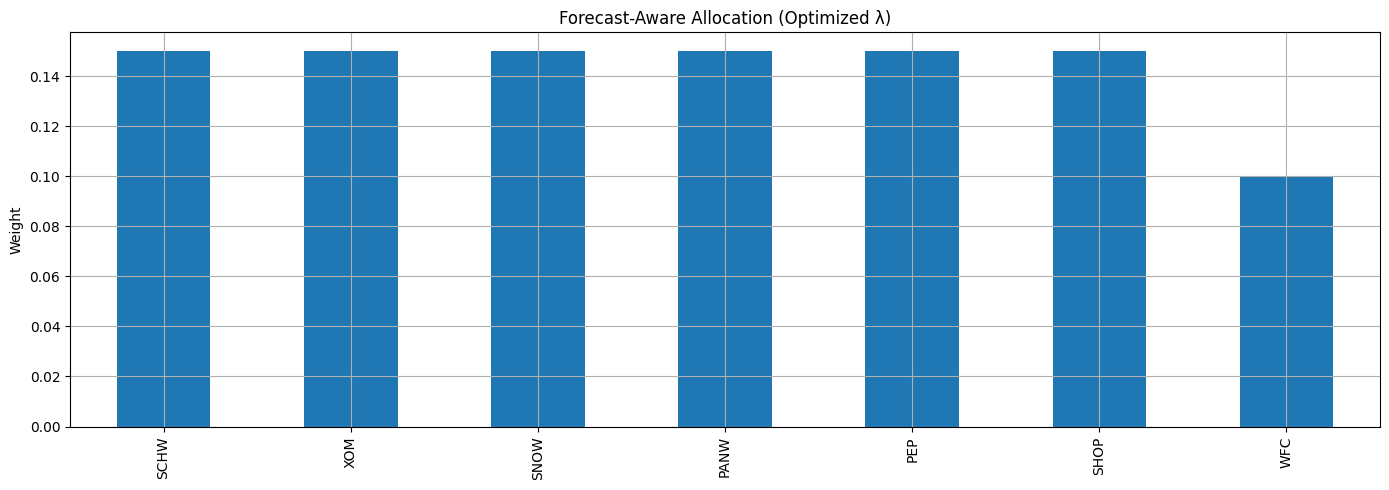

📈 Backtesting vs SPY...


[*********************100%***********************]  8 of 8 completed
C:\Users\chris\AppData\Local\Temp\ipykernel_21424\409472218.py:119: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


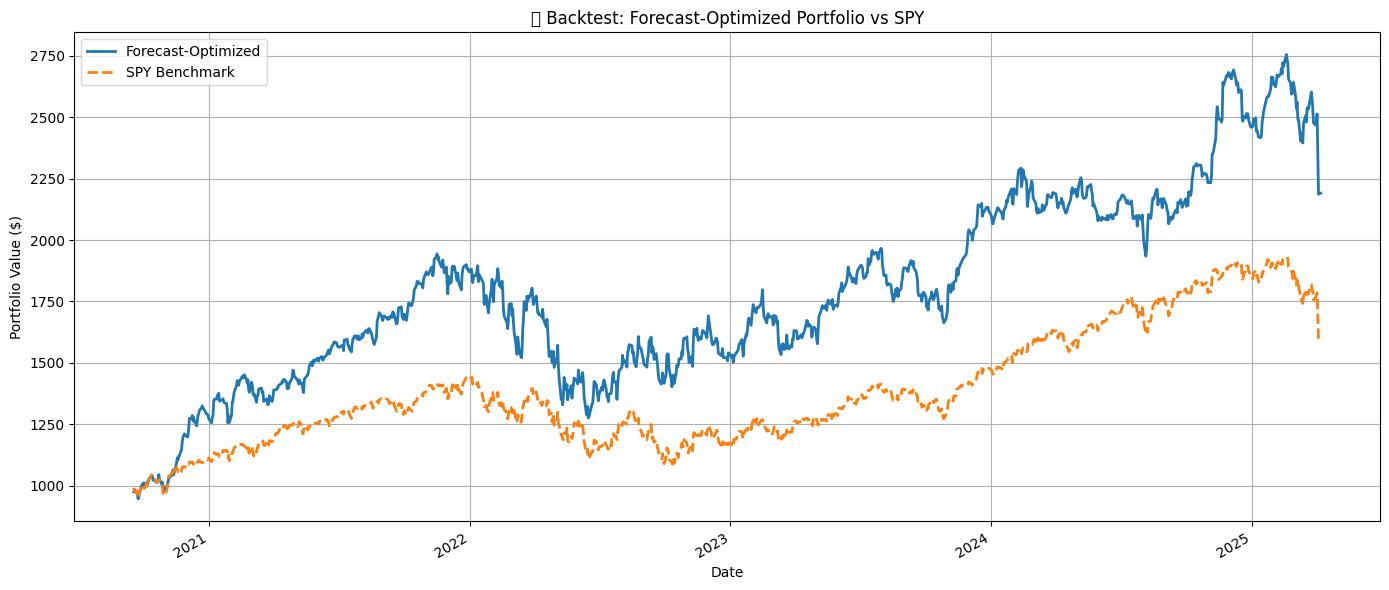

🔮 Forecasting future (2025–2030) with GBM...


C:\Users\chris\AppData\Local\Temp\ipykernel_21424\409472218.py:157: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\OneDrive\Desktop\PortfolioOptimization_V0.1\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


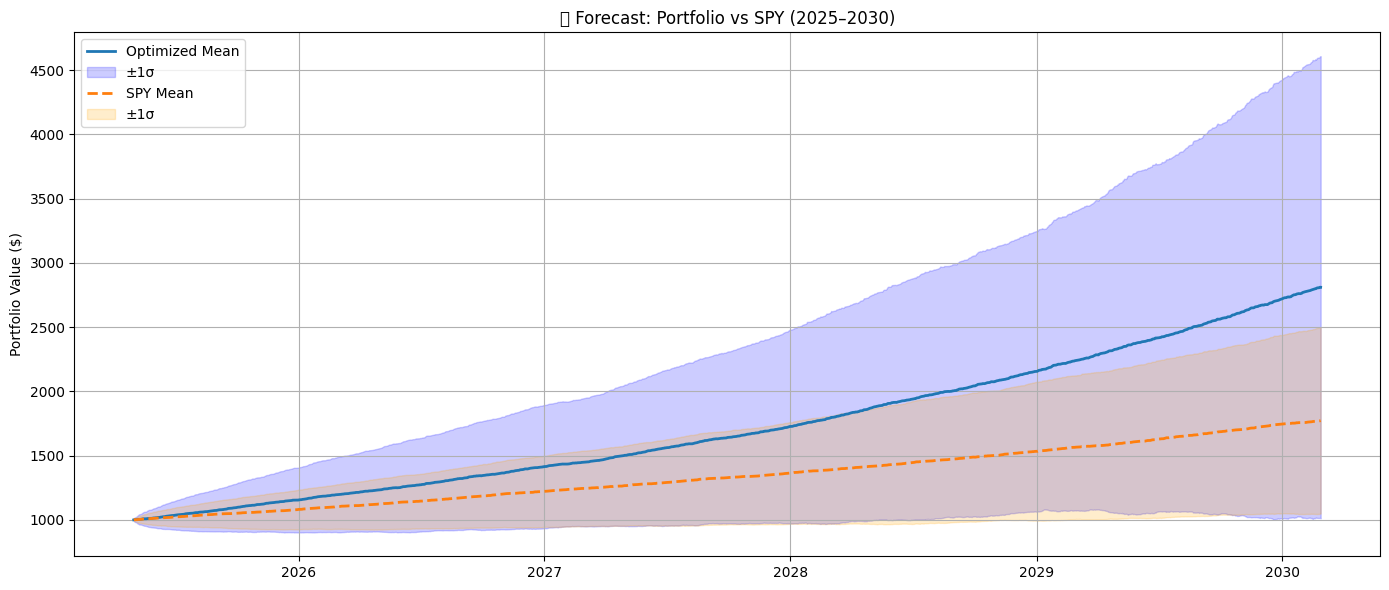

In [2]:
# Forecast-Aware Optimizer (012_forecast_optimizer.ipynb)

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import cvxpy as cp

# === Load Processed Data ===
returns = pd.read_csv("../data/processed/advanced_returns.csv", index_col=0, parse_dates=True)
assets = returns.columns

# === Forecast Expected Returns with Ridge Regression ===
print("🔮 Forecasting expected returns with Ridge Regression...")
forecast_horizon = 21  # ~1 month
n_assets = len(assets)
preds = []

for asset in assets:
    series = returns[asset].dropna()
    X = []
    y = []
    for i in range(len(series) - forecast_horizon):
        X.append(series[i:i+forecast_horizon].values)
        y.append(series[i+forecast_horizon])
    X, y = np.array(X), np.array(y)

    if len(X) < 50:
        preds.append(0)
        continue

    model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    model.fit(X, y)
    X_last = series[-forecast_horizon:].values.reshape(1, -1)
    pred = model.predict(X_last)[0]
    preds.append(pred)

expected_returns = pd.Series(preds, index=assets)
expected_returns = expected_returns.clip(lower=-0.05, upper=0.05)

print("✅ Forecasted expected returns (1-month):")
print(expected_returns.sort_values(ascending=False).head())

# === Estimate Covariance Matrix ===
cov_matrix = returns.cov()

# === Sharpe Maximization with Risk Constraint (CVaR) ===
print("⚙️ Running forecast-aware optimizer with dynamic λ...")

best_weights = None
best_sharpe = -np.inf
best_lambda = None

for lam in np.linspace(0, 1, 21):
    w = cp.Variable(n_assets)
    z = cp.Variable(returns.shape[0])
    VaR = cp.Variable()
    alpha = 0.95
    losses = -returns.values @ w
    cvar = VaR + (1 / ((1 - alpha) * returns.shape[0])) * cp.sum(z)

    objective = cp.Minimize(lam * cvar - (1 - lam) * expected_returns.values @ w)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 0.15,
        z >= 0,
        z >= losses - VaR
    ]

    problem = cp.Problem(objective, constraints)
    try:
        problem.solve()
        weights = pd.Series(w.value, index=assets)
        port_ret = expected_returns @ weights
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe = (port_ret - 0.02) / port_vol
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_lambda = lam
            best_weights = weights.copy()
    except:
        continue

print(f"✅ Optimal λ = {best_lambda:.2f} with Sharpe ≈ {best_sharpe:.3f}")
best_weights = best_weights[best_weights > 0.005].sort_values(ascending=False)

# === Plot Allocation ===
best_weights.plot(kind="bar", figsize=(14, 5), title="Forecast-Aware Allocation (Optimized λ)")
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Backtest vs SPY ===
print("📈 Backtesting vs SPY...")
data = yf.download(list(best_weights.index) + ["SPY"], start="2014-01-01", end="2025-04-30", group_by="ticker", auto_adjust=True)
price_df = pd.concat([data[ticker]["Close"] for ticker in best_weights.index], axis=1)
price_df.columns = best_weights.index
returns_live = price_df.pct_change().dropna()
opt_returns = (returns_live @ best_weights).dropna()
spy_returns = data['SPY']['Close'].pct_change().reindex(opt_returns.index).dropna()

opt_val = (1 + opt_returns).cumprod() * 1000
spy_val = (1 + spy_returns).cumprod() * 1000

plt.figure(figsize=(14, 6))
opt_val.plot(label="Forecast-Optimized", linewidth=2)
spy_val.plot(label="SPY Benchmark", linestyle="--", linewidth=2)
plt.title("📊 Backtest: Forecast-Optimized Portfolio vs SPY")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Forecast Future Performance ===
print("🔮 Forecasting future (2025–2030) with GBM...")
np.random.seed(42)
sim_days = 252 * 5
n_sim = 1000

mu_opt = opt_returns.mean()
sigma_opt = opt_returns.std()
mu_spy = spy_returns.mean()
sigma_spy = spy_returns.std()

opt_sim = np.zeros((sim_days, n_sim))
spy_sim = np.zeros((sim_days, n_sim))
opt_sim[0] = 1000
spy_sim[0] = 1000

for t in range(1, sim_days):
    opt_sim[t] = opt_sim[t - 1] * np.exp((mu_opt - 0.5 * sigma_opt**2) + sigma_opt * np.random.normal(0, 1, n_sim))
    spy_sim[t] = spy_sim[t - 1] * np.exp((mu_spy - 0.5 * sigma_spy**2) + sigma_spy * np.random.normal(0, 1, n_sim))

future_index = pd.date_range(start=pd.to_datetime("2025-05-01"), periods=sim_days, freq="B")
opt_mean = opt_sim.mean(axis=1)
spy_mean = spy_sim.mean(axis=1)
opt_std = opt_sim.std(axis=1)
spy_std = spy_sim.std(axis=1)

plt.figure(figsize=(14, 6))
plt.plot(future_index, opt_mean, label="Optimized Mean", linewidth=2)
plt.fill_between(future_index, opt_mean - opt_std, opt_mean + opt_std, alpha=0.2, color='blue', label="±1σ")
plt.plot(future_index, spy_mean, label="SPY Mean", linestyle="--", linewidth=2)
plt.fill_between(future_index, spy_mean - spy_std, spy_mean + spy_std, alpha=0.2, color='orange', label="±1σ")
plt.title("🔮 Forecast: Portfolio vs SPY (2025–2030)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
